In [1]:
import sys
print(sys.version)


3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


In [ ]:
device = 'cuda'

In [3]:
# this was implemented via Google Colab
!pip3 install torchtext
!pip3 install torch
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


<h1> Data Preprocessing</h1>

In [4]:
import numpy as np
import torch
from torchtext import data

print('PyTorch version:', torch.__version__)

# Set the random seeds for reproducibility
seed = 1234

torch.manual_seed(seed) 
torch.backends.cudnn.deterministic = True

# Field - specifies how the data should processed
# LabelField - special version of Field that specifies how to handle Labels
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

PyTorch version: 1.1.0


In [5]:
# import the sample dataset (IMDB) from PyTorch
# Canonically split the data into train and test set
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:09<00:00, 9.12MB/s]


In [6]:
print(train_data)

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [8]:
print(vars(train_data.examples[0]))

{'text': ['I', 'got', 'to', 'see', 'this', 'just', 'this', 'last', 'Friday', 'at', 'the', 'Los', 'Angeles', 'film', 'festival', 'at', 'Laemlee', "'s", 'on', 'Beverly', '.', 'This', 'movie', 'got', 'the', 'most', 'applause', 'of', 'all', 'the', 'films', 'that', 'evening', '.', 'Considering', 'that', 'two', 'music', 'videos', 'opened', 'first', ',', 'I', 'did', "n't", 'know', 'what', 'to', 'expect', 'since', 'they', 'were', 'very', 'fast', 'and', 'attention', 'grabbing', ',', 'I', 'was', "n't", 'sure', 'I', 'was', 'ready', 'for', 'a', 'short', 'immediately', '.', 'But', 'to', 'my', 'surprise', 'I', 'really', 'enjoyed', 'this', '.', 'I', 'thought', 'the', 'main', 'actor', 'demon', 'guy', 'was', 'really', 'good', '.', 'I', 'was', 'so', 'impressed', 'with', 'his', 'performance', 'that', 'I', 'checked', 'out', 'his', 'name', '.', 'I', 'was', 'surprised', 'to', 'see', 'that', 'this', 'was', 'the', 'Witchblade', 'guy', '.', 'He', "'s", 'gotten', 'really', 'good', 'especially', 'since', 'then',

In [ ]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(seed))

We'll be using the `glove.6B.100d" vectors`. glove is the algorithm used to calculate the vectors, go here for more. 6B indicates these vectors were trained on 6 billion tokens and 100d indicates these vectors are 100-dimensional.

The theory is that these pre-trained vectors already have words with similar semantic meaning close together in vector space, e.g. "terrible", "awful", "dreadful" are nearby. This gives our embedding layer a good initialization as it does not have to learn these relations from scratch.

In [10]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [00:53, 16.2MB/s]                           
100%|█████████▉| 399195/400000 [00:14<00:00, 26719.62it/s]

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

<h1>The Model</h1>

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


In [15]:
# display the shape
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [16]:
# replace the initial weights of the embedding layer with the pre-trained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)


tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.3844, -0.7040, -0.9940,  ..., -0.1486,  2.2851,  0.9289],
        [ 1.2595, -0.0763, -0.1569,  ..., -1.9728,  0.4010,  0.6415],
        [ 0.3555, -1.3517, -0.0088,  ...,  0.5276, -0.5721, -0.8456]])

In [17]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.3844, -0.7040, -0.9940,  ..., -0.1486,  2.2851,  0.9289],
        [ 1.2595, -0.0763, -0.1569,  ..., -1.9728,  0.4010,  0.6415],
        [ 0.3555, -1.3517, -0.0088,  ...,  0.5276, -0.5721, -0.8456]])


<h1>Training</h1>

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):

    # Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    
    # Round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# monitor the time an epoch takes to compare training times between models
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
N_EPOCHS = 5

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'modelv2.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

100%|█████████▉| 399195/400000 [00:30<00:00, 26719.62it/s]

Epoch: 01 | Epoch Time: 0m 42s
	Train Loss: 0.655 | Train Acc: 61.04%
	Val. Loss: 0.547 |  Val. Acc: 73.03%
Epoch: 02 | Epoch Time: 0m 43s
	Train Loss: 0.568 | Train Acc: 71.69%
	Val. Loss: 0.585 |  Val. Acc: 68.47%
Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 0.507 | Train Acc: 75.50%
	Val. Loss: 0.371 |  Val. Acc: 84.34%
Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.366 | Train Acc: 84.70%
	Val. Loss: 0.311 |  Val. Acc: 86.91%
Epoch: 05 | Epoch Time: 0m 44s
	Train Loss: 0.308 | Train Acc: 87.48%
	Val. Loss: 0.289 |  Val. Acc: 88.45%


<h1>Metrics</h1>

In [25]:
model.load_state_dict(torch.load('modelv2.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.306 | Test Acc: 87.26%


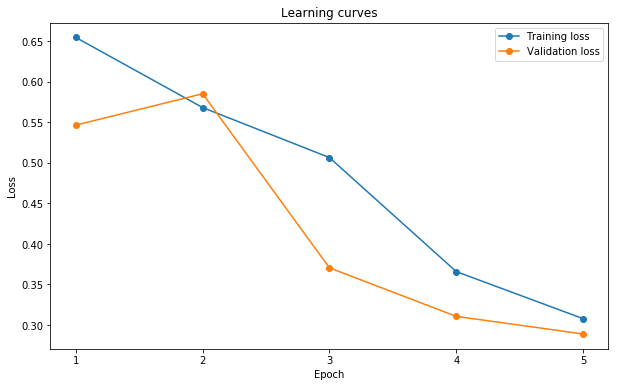

In [26]:
# Visualize the results after 5 epochs
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, '-o', label='Training loss')
plt.plot(epochs, valid_losses, '-o', label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()